### Data

In [383]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import glob
import random
import cv2
import imutils
from skimage import color

In [384]:
# Another dataset class incase mflickr is not enough data, based on a subset of Imagenet
class ImageNet(Dataset):
    '''
    Constructor 
    Inputs:
        root -> root dir of images,
        ext -> optional extension of images, default jpg
        size -> optional, crops data size for faster testing
    '''
    def __init__(self, root, ext='.JPEG', size=None, transform=None):
        self.paths = glob.glob(f'{root}/*{ext}', recursive=True)
        self.size = size
        self.root = root
        self.transform = transform
        self.height = 256
        self.width = 256
        
        if size: #speed up testing
            self.paths = self.paths[:size]
    
    '''
    get the img at index i
    '''
    def __getitem__(self, i):
        s = (self.paths[i])
        img = Image.open(s)
        if self.transform:
            img = self.transform(img)
        return img
    
    '''
    return length of dataset
    '''
    def __len__(self):
        return(len(self.paths))
    
    '''
    helper function that takes in original image, and returns 
    original size and resize grayscale (L) dimension
    '''
    def preprocess_img(self, img_rgb_orig, resample=3):
        img_rgb_rs = self.resize_img(img_rgb_orig) # original image resized
        
        img_lab_orig = color.rgb2lab(img_rgb_orig) # original image to lab space
        img_lab_rs = color.rgb2lab(img_rgb_rs)     # resized lab image 
        
        img_l_orig = img_lab_orig[:,:,0]           # original size L channel 
        img_l_rs = img_lab_rs[:,:,0]               # resize L channel
    
        tens_orig_l = torch.Tensor(img_l_orig)[None,:,:] # to tensor
        tens_rs_l = torch.Tensor(img_l_rs)[None,:,:]
    
        return (tens_orig_l, tens_rs_l)

    '''
    This function takes in an image and resizes it to 256 by 256
    '''
    def resize_img(self, img):
        return (img.resize((self.height, self.width), resample=3))
    
    '''
    Selects random start point in the dataset and prints 7 images
    Inputs:
        color-> 1 to print color images, 0 for grayscale images
    '''
    def print_samples(self):
        figure, axes = plt.subplots(1, 7, figsize=(18,10))
        axes = axes.flatten()
        max_idx = self.size if self.size!=None else len(self.paths)
        i = random.randint(0, max_idx)
        print("I",i)
        for axis in axes:
            x = self[i]
            axis.imshow(x)
            i+=1
        plt.show()
    
    '''
    prints all three LAB channels of a given image index.
    also demonstrates how to rebuild original image from l,a,b channels
    '''
    def print_lab_channels(self,index):
        img = self[index]
        img_lab = color.rgb2lab(img)
        l = torch.Tensor(img_lab[:,:,0])[None,:,:]
        a = torch.Tensor(img_lab[:,:,1])[None,:,:]
        b = torch.Tensor(img_lab[:,:,2])[None,:,:]
        figure, axes = plt.subplots(1, 5, figsize=(18,10))
        axes = axes.flatten()
        
        # Plot lab iamge and all 3 channels seperately
        axes[0].imshow(img_lab) # currently weird colors because img_lab contains negative values
        axes[0].set_xlabel("LAB image")
        axes[1].imshow(l.permute(1,2,0),cmap="gray")
        axes[1].set_xlabel("L Channel")
        axes[2].imshow(a.permute(1,2,0))
        axes[2].set_xlabel("A Channel")
        axes[3].imshow(b.permute(1,2,0))
        axes[3].set_xlabel("B Channel")
        
        # Rebuilding original image from l,a,b layers
        orig = torch.cat((l, a, b), dim=0)
        orig = orig.permute(1,2,0)
        orig = color.lab2rgb(orig)
        axes[4].imshow(orig)
        axes[4].set_xlabel("Rebuilt image")
        
        plt.tight_layout()
        plt.show()

    '''
    takes an index and prints the original plus the L channel image
    side by side
    '''
    def print_side_by_side(self,i):
        figure, axes = plt.subplots(1, 2, figsize=(18,10))
        axes = axes.flatten()
        img = temp[i]
        l_org, l_rs = preprocess_img(img)
        l_org = l_org.permute(1,2,0)
        axes[0].imshow(img)
        axes[1].imshow(l_org, cmap="gray")
        plt.tight_layout()
        plt.show()
        
    '''
    Calculates average width and height of all images in dataset
    '''
    def calc_average_dimension(self):
        totalw = 0
        totalh = 0
        for i in range(len(self.paths)):
            image = Image.open(self.paths[i])
            w, h = image.size
            totalw += w
            totalh += h
        avgw = totalw//len(self.paths)
        avgh = totalh//len(self.paths)
        return avgw, avgh

In [369]:
ImageNet_train_dataset = ImageNet(root="./imagenet/train")
ImageNet_eval_dataset = ImageNet(root="./imagenet/val")

In [370]:
train_dataloader_imagenet = DataLoader(ImageNet_train_dataset, batch_size=32, shuffle=True)
eval_dataloader_iamgenet = DataLoader(ImageNet_eval_dataset, batch_size=32, shuffle=True)

### Testing LAB conversion for ImageNet

In [371]:
temp = ImageNet(root="./imagenet/train",size=1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


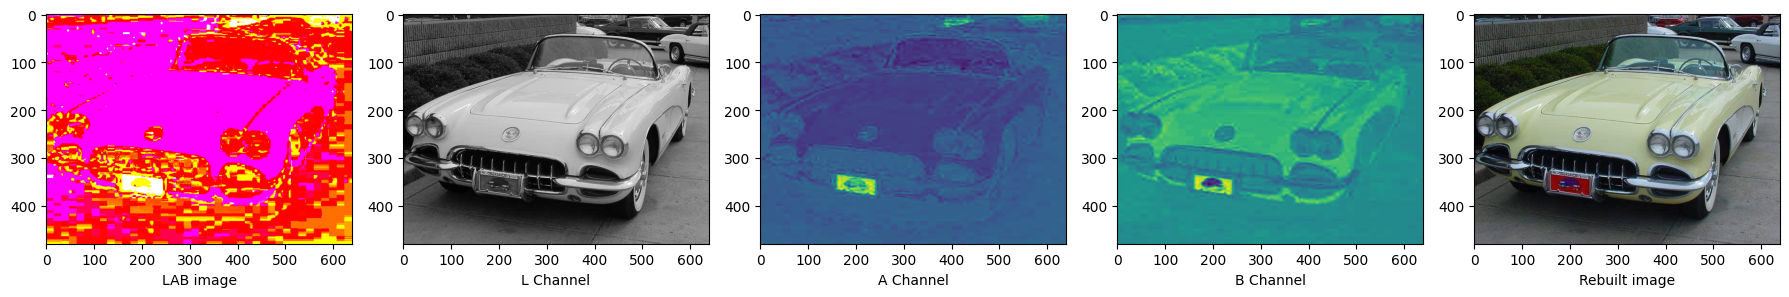

In [381]:
temp.print_lab_channels(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


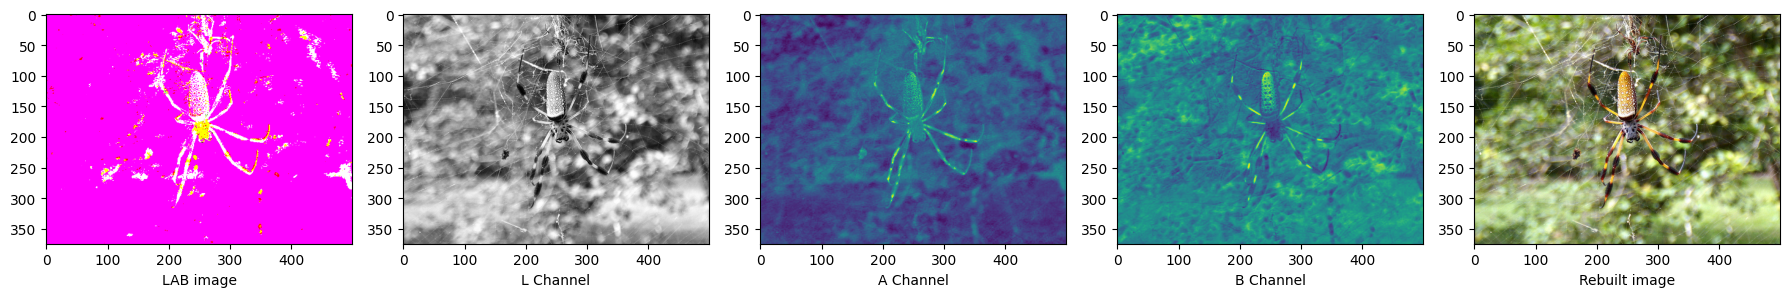

In [382]:
temp.print_lab_channels(1)

# Class for the mirFlickr dataset

In [148]:
# This code was based on the FlowerDataset class we did in Assignment 2
class VisionDataset(Dataset):
    '''
    Constructor 
    Inputs:
        root -> root dir of images,
        ext -> optional extension of images, default jpg
        size -> optional, crops data size for faster testing
    '''
    def __init__(self, root, ext='.jpg', size=None):
        self.paths = glob.glob(f'{root}/*{ext}', recursive=True)
        self.dataset = []         # array of tuples (black/white , original)
        self.size = size
        
        if size: #speed up testing
            self.paths = self.paths[:size]

    '''
    return length of dataset
    '''
    def __len__(self):
        return(len(self.paths))
    
    '''
    get the img,label tuple corresponding to index i
    '''
    def __getitem__(self, i):
        s = (self.root+'/'+self.paths[i])
        img = Image.open(s)
        if self.transform:
            img = self.transform(img)
        return img
    
    
    '''
    Selects random start point in the dataset and prints 7 images
    Inputs:
        color-> 1 to print color images, 0 for grayscale images
    '''
    def print_samples(self, color:int):
        figure, axes = plt.subplots(1, 7, figsize=(18,10))
        axes = axes.flatten()
        i = random.randint(0, self.size-29)
        
        for axis in axes:
            x = self.dataset[i]
            if color:
                axis.imshow(x[1])
            else:
                axis.imshow(x[0],cmap="gray")
            label = self.paths[i]
            axis.set_xlabel(label)
            i+=1
        plt.show()
    
    '''
    Calculates average width and height of all images in dataset
    '''
    def calc_average_dimension(self):
        totalw = 0
        totalh = 0
        for i in range(len(self.paths)):
            image = Image.open(self.paths[i])
            w, h = image.size
            totalw += w
            totalh += h
        avgw = totalw//len(self.paths)
        avgh = totalh//len(self.paths)
        return avgw, avgh

In [380]:
dataset = VisionDataset("./mirflickr", ext=".jpg", size=1000)
train_dataloader_vision = DataLoader(dataset, batch_size=32, shuffle=True)

In [151]:
# dataset.print_samples(color=0)

In [152]:
# dataset.print_samples(color=1)